行人检测

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# 关闭ssl证书验证，避免下载错误
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. 构建dataset数据集

In [25]:
# 定义数据生成器
# data_path:/Users/liuliangdong/project/jupyter_project/datasets/pytorch_data/PennFudanPed
class PennFudanDataset:
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # 读取所有图片确保一一对应
        self.images = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))
    
    def __getitem__(self, idx):
        # 拼接路径 加载图片和masK
        img_path = os.path.join(self.root, 'PNGImages', self.images[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        
        # 使用image读取,并使用RGB转码
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        # 将mask转为np.array
        mask = np.array(mask)
        # 实例编码为不同意思
        obj_ids = np.unique(mask)   
        obj_ids = obj_ids[1:]     # 第一个为背景颜色，移除
        
        # 将颜色编码划分为蒙版标记
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        # 获取蒙板轮廓
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        # 将所有数据转化为tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        return image, target
    
    def __len__(self):
        return len(self.images)
    

## 2. 构建微调模型

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
# 获取分类的输入特征
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 3.修改模型并添加其他主干

In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [8]:
# 加载预训练模型且只返回一个特征
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN中需要知道主干输出的特征数，在mobilenet_v2中是1280
backbone.out_channels = 1280

# 另RPN在空间位置中生成5*3的锚点，5个不同大小和3个方位尺寸比例，每个图片有不同的长宽比
anchor_Generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ),
                                  aspect_ratios=((0.5, 1.0, 2.0), ))

# 特征图：用于对感兴趣区域的裁剪，及对缩放后图片的尺寸调整。如果模型主干返回一个tensor,
# 则特征图名称为[0], 可以在特征图名称中选择一个使用
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                               output_size=7,
                                               sampling_ratio=2)

# 将组件放到一个faster model 中
model = FasterRCNN(backbone, 
                  num_classes,
                  rpn_anchor_generator=anchor_Generator,
                  box_roi_pool=roi_pooler)


### 3.数据集的实例细分模型

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [22]:
def get_model_instance_segmentation(num_classes):
    # 加载预训练好的模型
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # 获取分类器输入特征数
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 替换模型的头部
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 获取掩码分类器的特征数量
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # 同样的替换掩码分类器的头部信息，
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model


### 4.将所有组件放在一起

In [17]:
import transforms as T
def get_transforms(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        
    return T.Compose(transforms)

In [23]:
import utils
from engine import evaluate, train_one_epoch
# 创建主程序
def main():
    path = r'/Users/liuliangdong/project/jupyter_project/datasets/pytorch_data/PennFudanPed'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
    
    # 数据集仅两类，行人和背景
    num_classes = 2
    dataset = PennFudanDataset(path, get_transforms(train=True))
    dataset_test = PennFudanDataset(path, get_transforms(train=False))    
    
    # 划分数据集为训练集和测试集
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])    
    dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
    
    # 定义训练和验证集的加载器
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn
    )
    
    data_loader_test = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn
    )
    
    # 使用辅助函数
    model = get_model_instance_segmentation(num_classes)
    model.to(device)
    
    # 创建优化器
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # 给定学习率
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    # 训练10轮
    num_epochs = 10

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # 更新学习率
        lr_scheduler.step()
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [27]:
main()

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 324, in reduce_storage
    metadata = storage._share_filename_()
RuntimeError: error executing torch_shm_manager at "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/bin/torch_shm_manager" at ../torch/lib/libshm/core.cpp:99
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/mult

KeyboardInterrupt: 

In [13]:
path = r'/Users/liuliangdong/project/jupyter_project/datasets/pytorch_data/PennFudanPed'
pfd = PennFudanDataset(path)

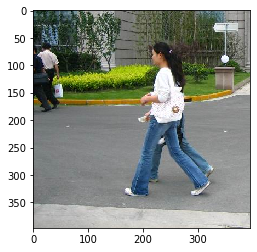

In [8]:
data = np.array(pfd.__getitem__(3))
plt.imshow(data[0])
plt.show()